In [ ]:
VOCAB_SIZE = 300  # 사용할 단어 수
SEQ_LEN = 100     # 시퀀스 하나의 최대 길이

In [2]:
# 데이터 로드
from tensorflow.keras.datasets import imdb

(train_input, train_target), (test_input, test_target) =  imdb.load_data(num_words=VOCAB_SIZE)


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# PyTorch Teensor 로 변환
import torch

# torch.tensor() :  ndarray -> torch의 tensor형태로 변환
train_input = [torch.tensor(seq,dtype=torch.long) for seq in train_input]
test_input = [torch.tensor(seq, dtype=torch.long) for seq in test_input]

train_target = torch.tensor(train_target, dtype = torch.long)
test_target = torch.tensor(test_target, dtype = torch.long)

print(len(train_input), len(test_input))
print(train_target.shape, test_target.shape)

25000 25000
torch.Size([25000]) torch.Size([25000])


In [4]:
train_input, test_input = train_input[:10000], test_input[:5000]
train_target, test_target = train_target[:10000], test_target[:5000]


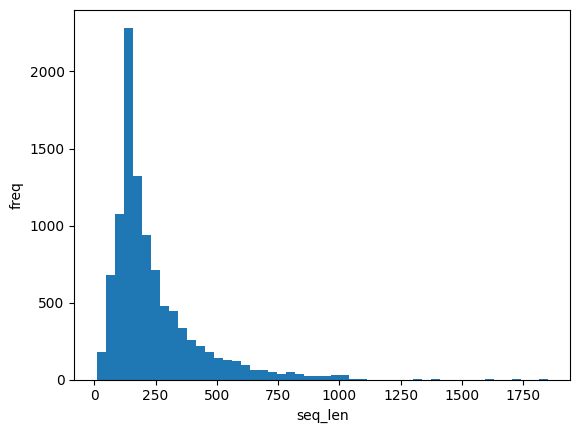

In [5]:
# 입력데이터 길이 체크
import matplotlib.pyplot as plt
import numpy as np

train_len = [len(seq) for seq in train_input]

plt.hist(train_len, bins=50)
plt.xlabel('seq_len')
plt.ylabel('freq')
plt.show()

In [ ]:
# padding 처리
import torch.nn.functional as F

# F.pad() : 텐서의 특정 차원에 padding을 추가하는 함수
# pad(input, pad, mode='constant', value=0) -> Tensor
# input : padding을 추가할 텐서
# pad : 각 차원에 추가할 padding의 양을 지정하는 튜플
# mode : padding 방법을 지정하는 문자열
# value : mode가 'constant'인 경우 padding에 사용할 상수값
# mode='constant' : 상수값으로 padding을 채움

def pad_sequences(sequences, maxlen, padding_value=0):
  # seq[:maxlen] : seq의 길이가 maxlen보다 길면 maxlen만큼 잘라냄
  # (0,max(0,maxlen-len(seq))) : seq의 길이가 maxlen보다 짧으면 0으로 채움
  # value : padding_value로 채움
  padded_sequences = [F.pad(seq[:maxlen], (0,max(0,maxlen-len(seq))), value=padding_value) for seq in sequences]
  return torch.stack(padded_sequences)  # torch.stack을 이용해 단일 텐서로 만듬

train_seq = pad_sequences(train_input, maxlen=SEQ_LEN)
test_seq = pad_sequences(test_input, maxlen=SEQ_LEN)

train_seq.shape, test_seq.shape

(torch.Size([10000, 100]), torch.Size([5000, 100]))

In [8]:
# one-hot encoding
train_onehot = F.one_hot(train_seq, num_classes=VOCAB_SIZE).float()
test_onehot = F.one_hot(test_seq, num_classes=VOCAB_SIZE).float()

# 1. 시퀀스개수
# 2. 토큰개수
# 3. 원핫인코딩 차원의 개수
train_onehot.shape, test_onehot.shape

(torch.Size([10000, 100, 300]), torch.Size([5000, 100, 300]))

In [9]:
import torch.nn as nn
class SentimentRNN(nn.Module):
  def __init__(self, seq_len, vocab_size, hidden_dim, output_dim):
    super(SentimentRNN, self).__init__()
    self.rnn = nn.RNN(input_size=vocab_size, hidden_size=hidden_dim, batch_first=True)  # RNN안에 활성화 함수가 적용돼 있기에 굳이 따로 적용 필요 X
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.sigmoid = nn.Sigmoid()

  def forward(self,x):
    _, hidden = self.rnn(x) # RNN을 지나 출력층으로 보냄
    out = self.fc(hidden.squeeze(0))  # 출력층에서 선형으로 차원제거
    return self.sigmoid(out)  # 활성화 함수 적용

In [10]:
HIDDEN_DIM = 8
OUTPUT_DIM = 1

model = SentimentRNN(seq_len=SEQ_LEN, vocab_size=VOCAB_SIZE, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM)
print(model)

SentimentRNN(
  (rnn): RNN(300, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
total_params = 0
print(f"{'Layer':<20} {'Shape':<30} {'Params'}")
print("=" * 60)

for name, param in model.named_parameters():  # 학습 가능한 모든 파라미터 정보를 반환해 반복
  if param.requires_grad:   # 역전파가 이뤄나 학습을 반환하는 파라미터인지 확인
    param_count = param.numel() # numel() : 파라미터의 개수를 반환
    total_params += param_count
    print(f'{name:<20} {str(list(param.shape)):<30} {param_count}')

print("=" * 60)
print(f'Total Trainable Parameters: {total_params}')
# rnn.weight_ih_l0 : 입력층 은닉층 가중치
# rnn.weight_hh_l0 : 은닉층 은닉층 가중치
# rnn.bias_ih_l0 : 입력층 은닉층 편향
# rnn.bias_hh_l0 : 은닉층 은닉층 편향

Layer                Shape                          Params
rnn.weight_ih_l0     [8, 300]                       2400
rnn.weight_hh_l0     [8, 8]                         64
rnn.bias_ih_l0       [8]                            8
rnn.bias_hh_l0       [8]                            8
fc.weight            [1, 8]                         8
fc.bias              [1]                            1
Total Trainable Parameters: 2489


In [ ]:
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, random_split

BATCH_SIZE = 65
train_size = int(len(train_onehot) *0.8)
val_size = len(train_onehot) - train_size

train_target = train_target.float()
test_target = test_target.float()

train_dataset, val_dataset = random_split(TensorDataset(train_onehot, train_target), [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

Epoch 1/100 | Train Loss: 0.6385 | Train Acc: 0.5793 | Val Loss: 0.6451 | Val Acc: 0.5775
Epoch 2/100 | Train Loss: 0.6347 | Train Acc: 0.5910 | Val Loss: 0.6376 | Val Acc: 0.5810
Epoch 3/100 | Train Loss: 0.6296 | Train Acc: 0.5919 | Val Loss: 0.6447 | Val Acc: 0.5855
Epoch 4/100 | Train Loss: 0.6284 | Train Acc: 0.5925 | Val Loss: 0.6360 | Val Acc: 0.5815
Epoch 5/100 | Train Loss: 0.6282 | Train Acc: 0.5981 | Val Loss: 0.6399 | Val Acc: 0.5835
Epoch 6/100 | Train Loss: 0.6283 | Train Acc: 0.5972 | Val Loss: 0.6503 | Val Acc: 0.5670
Epoch 7/100 | Train Loss: 0.6395 | Train Acc: 0.5887 | Val Loss: 0.6478 | Val Acc: 0.5735
Epoch 8/100 | Train Loss: 0.6340 | Train Acc: 0.5889 | Val Loss: 0.6512 | Val Acc: 0.5685
Epoch 9/100 | Train Loss: 0.6322 | Train Acc: 0.5899 | Val Loss: 0.6533 | Val Acc: 0.5685
Epoch 10/100 | Train Loss: 0.6262 | Train Acc: 0.6025 | Val Loss: 0.6468 | Val Acc: 0.5790
Epoch 11/100 | Train Loss: 0.6228 | Train Acc: 0.6016 | Val Loss: 0.6503 | Val Acc: 0.5750
Early st

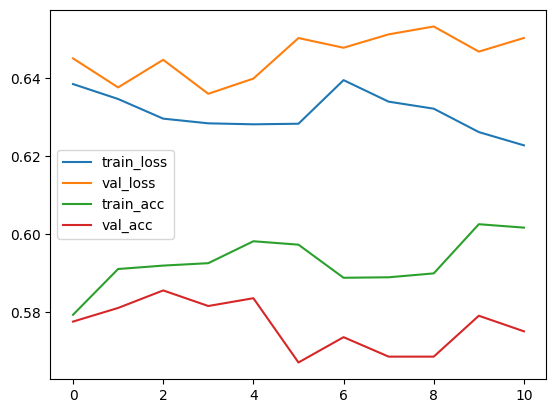

In [19]:
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, random_split

# 배치 사이즈 설정 + 학습/검증셋 크기 설정
BATCH_SIZE = 65
train_size = int(len(train_onehot) * 0.8)
val_size = len(train_onehot) - train_size

# label 데이터 실수 처리
train_target = train_target.float()
test_target = test_target.float()

# 학습/검증셋 분할 + 미니배치로 사용하도록 DataLoader 생성
train_dataset, val_dataset = random_split(
    TensorDataset(train_onehot, train_target), [train_size, val_size]
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# epoch, 손실함수, 최적화함수 정의
epochs = 100
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)


# 시각화를 위한 손실값/정확도 저장용
train_losses, val_losses, train_accs, val_accs = [], [], [], []

# 조기종료 관련 변수 초기화
early_stopping_patience = 7
best_val_loss = float("inf")
early_stop_counter = 0

for epoch in range(epochs):
    # train mode
    model.train()
    total_loss, correct, total = 0, 0, 0

    for inputs, targets in train_loader:
        optimizer.zero_grad()  # 가중치 초기화
        outputs = model(inputs).squeeze()  # 순전파

        loss = criterion(outputs, targets)  # 손실계산

        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트
        total_loss += loss.item()

        pred = (outputs > 0.5).float()
        correct += (pred == targets).sum().item()
        total += targets.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # validation mode
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_outputs = model(val_inputs).squeeze()
            loss = criterion(val_outputs, val_targets)
            val_loss += loss.item()

            val_pred = (val_outputs > 0.5).float()
            val_correct += (val_pred == val_targets).sum().item()
            val_total += val_targets.size(0)

    val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(
        f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
    )

    # 조기종료
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

train_history_df = pd.DataFrame(
    {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_acc": train_accs,
        "val_acc": val_accs,
    }
)
train_history_df.plot()
plt.show()